In [5]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

df = pd.read_csv('../data/ecom_events.csv')



In [6]:
df.head()

,event_time,event_type,product_id,category_id,category_code,brand,price,user_id,user_session
0,2019-10-01 00:00:00 UTC,view,44600062,2103807459595387724,NaN,shiseido,35.79,541312140,72d76fde-8bb3-4e00-8c23-a032dfed738c
1,2019-10-01 00:00:00 UTC,view,3900821,2053013552326770905,appliances.environment.water_heater,aqua,33.20,554748717,9333dfbd-b87a-4708-9857-6336556b0fcc
2,2019-10-01 00:00:01 UTC,view,17200506,2053013559792632471,furniture.living_room.sofa,NaN,543.10,519107250,566511c2-e2e3-422b-b695-cf8e6e792ca8
3,2019-10-01 00:00:01 UTC,view,1307067,2053013558920217191,computers.notebook,lenovo,251.74,550050854,7c90fc70-0e80-4590-96f3-13c02c18c713
4,2019-10-01 00:00:04 UTC,view,1004237,2053013555631882655,electronics.smartphone,apple,1081.98,535871217,c6bd7419-2748-4c56-95b4-8cec9ff8b80d


In [8]:
df['event_time'] = pd.to_datetime(df['event_time'])

df.fillna({'brand': 'unknown', 'category_code': 'unknown'}, inplace=True)

print(df['event_type'].value_counts())

print(df.isnull().sum())

event_type
view        97130
purchase     1655
cart         1215
Name: count, dtype: int64
event_time       0
event_type       0
product_id       0
category_id      0
category_code    0
brand            0
price            0
user_id          0
user_session     0
dtype: int64


In [ ]:
from collections import Counter

funnel = Counter(df['event_type'])
print(f"Views: {funnel['view']}")
print(f"Cart Adds: {funnel['cart']}")
print(f"Purchases: {funnel['purchase']}")

cart_rate = funnel['cart'] / funnel['view'] * 100
purchase_rate = funnel['purchase'] / funnel['view'] * 100

print(f"Cart Rate: {cart_rate:.2f}%")
print(f"Purchase Rate: {purchase_rate:.2f}%")



Views: 97130
Cart Adds: 1215
Purchases: 1655
Cart Rate: 1.25%
Purchase Rate: 1.70%


In [10]:
total_revenue = df[df['event_type'] == 'purchase']['price'].sum()
print(f"Total Revenue: ₹{total_revenue:,.2f}")


Total Revenue: ₹501,176.21


In [11]:
top_categories = df[df['event_type'] == 'view']['category_code'].value_counts().head(10)
print(top_categories)


category_code
unknown                             32072
electronics.smartphone              25113
electronics.clocks                   3085
computers.notebook                   2649
electronics.audio.headphone          2462
electronics.video.tv                 1918
appliances.kitchen.refrigerators     1912
appliances.environment.vacuum        1610
apparel.shoes                        1575
appliances.kitchen.washer            1492
Name: count, dtype: int64


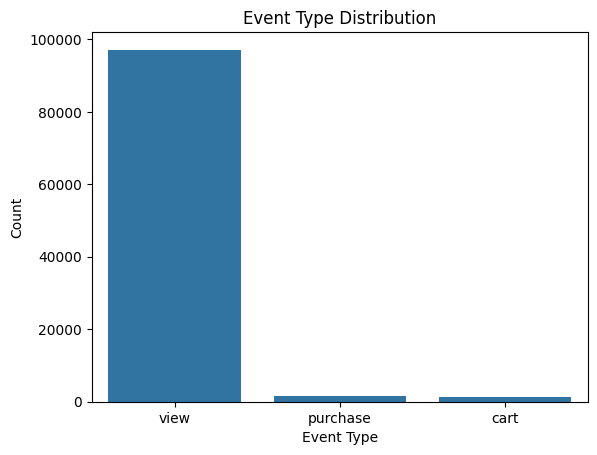

In [12]:
event_counts = df['event_type'].value_counts()
sns.barplot(x=event_counts.index, y=event_counts.values)
plt.title("Event Type Distribution")
plt.xlabel("Event Type")
plt.ylabel("Count")
plt.show()


In [14]:
import sqlite3
df = pd.read_csv('../data/ecom_events.csv')

conn = sqlite3.connect('../data/ecom.db')

In [15]:
df.to_sql('events', conn, if_exists='replace', index=False)
print("Table events loaded with", len(df), "rows.")

Table events loaded with 100000 rows.


In [ ]:
pd.read_sql_query("SELECT event_type, COUNT(*) FROM events GROUP BY event_type", conn)


In [16]:
def query_file(filename):
    with open(filename, 'r') as file:
        query = file.read()
    return pd.read_sql_query(query, conn)


In [17]:
df_conversions = query_file('../sql/conversion.sql')

In [18]:
df_conversions.head()

,event_type,count
0,cart,1215
1,purchase,1655
2,view,97130


In [31]:
df_revenue = query_file('../sql/total_rev.sql')
df_revenue.head()

,category_code,total_revenue
0,electronics.smartphone,346732.42
1,unknown,54849.12
2,computers.notebook,16137.95
3,electronics.video.tv,14039.82
4,appliances.kitchen.washer,10239.12


In [33]:
df_cart_aban = query_file('../sql/cart_abandonment_rate.sql')
df_cart_aban.head()

,cart_conversion_rate,purchase_from_cart_rate
0,1.25,136.21


In [34]:
df_daily_pur = query_file('../sql/daily_purchase.sql')
df_daily_pur.head()

,date,purchases
0,None,1655


In [36]:
df_most_viewd = query_file('../sql/most_viewed_brands.sql')
df_most_viewd.head()

,brand,views
0,unknown,14232
1,samsung,10793
2,apple,9019
3,xiaomi,6666
4,huawei,2576


In [41]:
df_unique_session = query_file('../sql/unique_session.sql')
df_unique_session.head()


,category_code,unique_sessions
0,unknown,8978
1,electronics.smartphone,7853
2,electronics.clocks,997
3,electronics.audio.headphone,921
4,computers.notebook,601


In [42]:
from pathlib import Path

In [43]:
export_dir = Path('../output')
export_dir.mkdir(exist_ok = True)

In [44]:
df_event_counts = pd.read_sql_query("""
    SELECT event_type, COUNT(*) AS count
    FROM events
    GROUP BY event_type             
""", conn)

df_event_counts.to_csv(export_dir/ 'event_counts.csv', index = False)


In [45]:
df_revenue = pd.read_sql_query("""
    SELECT 
        COALESCE(category_code, 'unknown') AS category_code,
        ROUND(SUM(price), 2) AS total_revenue
    FROM events
    WHERE event_type = 'purchase'
    GROUP BY COALESCE(category_code, 'unknown')
    ORDER BY total_revenue DESC
    LIMIT 10
""", conn)
df_revenue.to_csv(export_dir / 'top_categories_revenue.csv', index=False)


In [46]:
df_top_brands = pd.read_sql_query("""
    SELECT 
        COALESCE(brand, 'unknown') AS brand,
        COUNT(*) AS views
    FROM events
    WHERE event_type = 'view'
    GROUP BY COALESCE(brand, 'unknown')
    ORDER BY views DESC
    LIMIT 10
""", conn)
df_top_brands.to_csv(export_dir / 'top_brands_views.csv', index=False)


In [47]:
df_funnel = pd.read_sql_query("""
    SELECT event_type, COUNT(*) AS count
    FROM events
    WHERE event_type IN ('view', 'cart', 'purchase')
    GROUP BY event_type
""", conn)
df_funnel.to_csv(export_dir / 'conversion_funnel.csv', index=False)


In [48]:
df_cart_abandon = pd.read_sql_query("""
    WITH cart_counts AS (
        SELECT COALESCE(category_code, 'unknown') AS category_code, COUNT(*) AS cart_count
        FROM events
        WHERE event_type = 'cart'
        GROUP BY COALESCE(category_code, 'unknown')
    ),
    purchase_counts AS (
        SELECT COALESCE(category_code, 'unknown') AS category_code, COUNT(*) AS purchase_count
        FROM events
        WHERE event_type = 'purchase'
        GROUP BY COALESCE(category_code, 'unknown')
    )
    SELECT 
        c.category_code,
        c.cart_count,
        COALESCE(p.purchase_count, 0) AS purchase_count
    FROM cart_counts c
    LEFT JOIN purchase_counts p
    ON c.category_code = p.category_code
    ORDER BY c.cart_count DESC
    LIMIT 10
""", conn)
df_cart_abandon.to_csv(export_dir / 'cart_abandonment.csv', index=False)


In [49]:
df_daily = pd.read_sql_query("""
    SELECT DATE(event_time) AS date, COUNT(*) AS daily_purchases
    FROM events
    WHERE event_type = 'purchase'
    GROUP BY DATE(event_time)
    ORDER BY date
""", conn)
df_daily.to_csv(export_dir / 'daily_purchase_trend.csv', index=False)


In [50]:
df_unique_sess = pd.read_sql_query("""
    SELECT 
        COALESCE(category_code, 'unknown') AS category_code,
        COUNT(DISTINCT user_session) AS unique_sessions
    FROM events
    WHERE event_type = 'view'
    GROUP BY COALESCE(category_code, 'unknown')
    ORDER BY unique_sessions DESC
    LIMIT 10
""", conn)
df_unique_sess.to_csv(export_dir / 'unique_sessions.csv', index=False)